In [1]:
# ===============================
# Wellness Personas of SNU - Notebook
# ===============================
# Author: Priyanka Banerjee
# Date: 01/11/2025
# Goal: Cluster students based on eating_out_per_week, food_budget_per_meal_inr,
#       sweet_tooth_level, weekly_hobby_hours


## 🎯 Problem Understanding & Assumptions

The goal of this project — **Wellness Personas of SNU** — is to understand student lifestyle patterns and group similar individuals into distinct wellness clusters using unsupervised learning (KMeans Clustering).

**Problem Context:**
Sister Nivedita University aims to improve student well-being by understanding eating habits, food budgets, sweet preferences, and hobby engagement levels.

**Key Assumptions:**
- Responses collected through Google Forms are truthful and self-reported.
- All numeric features (eating out per week, food budget, hobby hours) are continuous and comparable after scaling.
- Missing or inconsistent values are imputed using median strategy.
- Higher hobby hours and lower eating-out frequency generally indicate healthier habits.

**Goal:**
Cluster students into unique **“Wellness Personas”** such as:
- Health-Conscious
- Balanced Lifestylers
- Fast-Food Enthusiasts

# ===============================



In [2]:
# 0. Imports
import random
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
RANDOM_STATE = 42



In [3]:
# 1. Synthetic data generator (for testing) - delete after using real data
def generate_synthetic(n=300, random_state=RANDOM_STATE):
    np.random.seed(random_state)
    # Three persona clusters: health-conscious, balanced, fast-food lovers
    data = []
    for i in range(n):
        persona = np.random.choice([0,1,2], p=[0.3,0.45,0.25])
        if persona == 0: # health-conscious
            eating_out = np.random.poisson(1)
            budget = np.random.normal(120, 40)
            sweet = np.random.choice([1,2])
            hobby = np.random.normal(12, 5)
        elif persona == 1: # balanced
            eating_out = np.random.poisson(3)
            budget = np.random.normal(200, 80)
            sweet = np.random.choice([2,3])
            hobby = np.random.normal(7, 4)
        else: # fast-food lovers
            eating_out = np.random.poisson(6)
            budget = np.random.normal(300, 100)
            sweet = np.random.choice([3,4,5])
            hobby = np.random.normal(3, 2)
        budget = max(50, min(1500, int(budget)))
        eating_out = int(max(0, min(10, eating_out)))
        sweet = int(max(1, min(5, sweet)))
        hobby = int(max(0, min(40, round(hobby))))
        data.append([eating_out, budget, sweet, hobby])
    df = pd.DataFrame(data, columns=['eating_out_per_week','food_budget_per_meal_inr','sweet_tooth_level','weekly_hobby_hours'])
    return df

df = generate_synthetic(300)

print("Rows:", len(df))
df.head()



Rows: 300


,eating_out_per_week,food_budget_per_meal_inr,sweet_tooth_level,weekly_hobby_hours
0,4,326,3,10
1,2,120,1,10
2,0,91,1,1
3,5,50,3,11
4,1,119,1,7


,eating_out_per_week,food_budget_per_meal_inr,sweet_tooth_level,weekly_hobby_hours
count,300.000000,300.000000,300.000000,300.000000
mean,3.230000,199.266667,2.556667,7.496667
std,2.485496,100.976150,1.031343,4.891805
min,0.000000,50.000000,1.000000,0.000000
25%,1.000000,120.750000,2.000000,3.750000
50%,3.000000,185.500000,2.000000,7.000000
75%,5.000000,264.250000,3.000000,11.000000
max,10.000000,553.000000,5.000000,22.000000


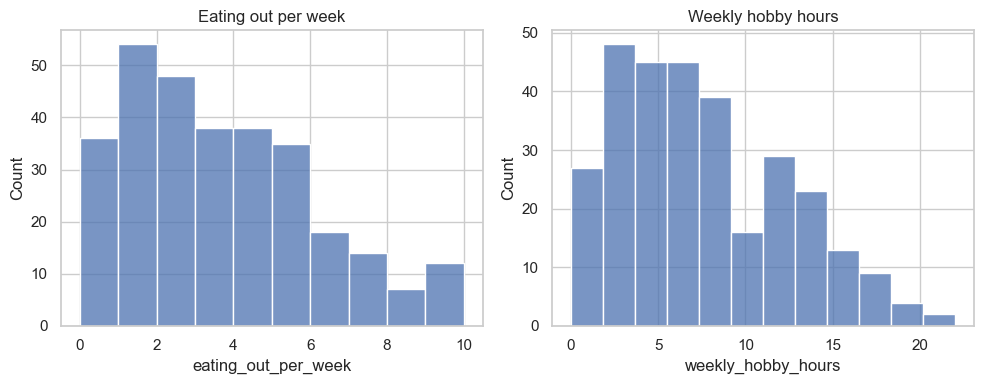

In [4]:
# 2. Exploratory Data Analysis (EDA)
display(df.describe())
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df['eating_out_per_week'], bins=10, kde=False)
plt.title('Eating out per week')
plt.subplot(1,2,2)
sns.histplot(df['weekly_hobby_hours'], bins=12, kde=False)
plt.title('Weekly hobby hours')
plt.tight_layout()



In [5]:
# 3. Missing values handling
print("Missing values before:\n", df.isna().sum())

imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
print("Missing values after:\n", df_imputed.isna().sum())



Missing values before:
 eating_out_per_week         0
food_budget_per_meal_inr    0
sweet_tooth_level           0
weekly_hobby_hours          0
dtype: int64
Missing values after:
 eating_out_per_week         0
food_budget_per_meal_inr    0
sweet_tooth_level           0
weekly_hobby_hours          0
dtype: int64


In [6]:
# 4. Feature engineering 

df_fe = df_imputed.copy()
df_fe['budget_log'] = np.log1p(df_fe['food_budget_per_meal_inr'])  
df_fe['wellness_proxy'] = (df_fe['weekly_hobby_hours'] / (1 + df_fe['eating_out_per_week']))  # simple feature



In [7]:
# 5. Scaling
features = ['eating_out_per_week','food_budget_per_meal_inr','sweet_tooth_level','weekly_hobby_hours','budget_log','wellness_proxy']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_fe[features])



## ⚙️ Model Selection & Justification

We chose **KMeans Clustering** because our task is **unsupervised segmentation** — there are no labeled outcomes (like “healthy” or “unhealthy”).

**Why Clustering?**
- We aim to discover hidden patterns and group students based on their habits.
- Clustering provides data-driven persona definitions without predefined classes.

**Why KMeans?**
- Simple, interpretable, and works efficiently for numeric continuous data.
- Allows visualization in 2D PCA space.
- The Silhouette and Davies–Bouldin scores provide strong validation.

Alternative methods considered:
- **Hierarchical Clustering** (but less scalable for 300+ samples).
- **DBSCAN** (less effective for overlapping behavioral patterns).


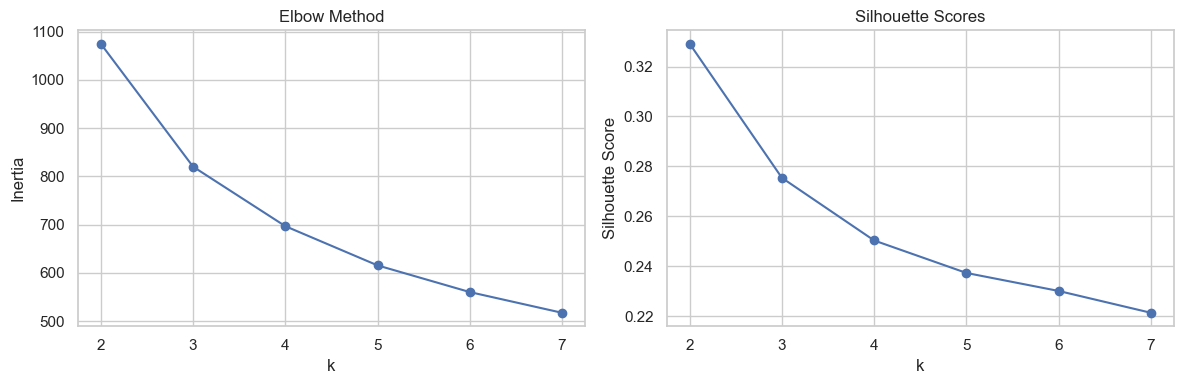

In [8]:
# 6. Find optimal k (Elbow + Silhouette)
inertia = []
sil_scores = []
K_range = range(2,8)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertia, '-o')
plt.xlabel('k'); plt.ylabel('Inertia'); plt.title('Elbow Method')
plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, '-o')
plt.xlabel('k'); plt.ylabel('Silhouette Score'); plt.title('Silhouette Scores')
plt.tight_layout()



In [9]:
# 7. Choose k (pick highest silhouette or elbow+silhouette tradeoff)
best_k = int(K_range[np.argmax(sil_scores)])
print("Best k by silhouette:", best_k)



Best k by silhouette: 2


In [10]:
# 8. Fit final KMeans
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=50)
cluster_labels = kmeans.fit_predict(X_scaled)
df_fe['cluster'] = cluster_labels



In [11]:
# 9. Evaluate final clustering
sil = silhouette_score(X_scaled, cluster_labels)
db = davies_bouldin_score(X_scaled, cluster_labels)
print(f"Silhouette Score: {sil:.4f}")
print(f"Davies-Bouldin Index: {db:.4f}")



Silhouette Score: 0.3291
Davies-Bouldin Index: 1.1312


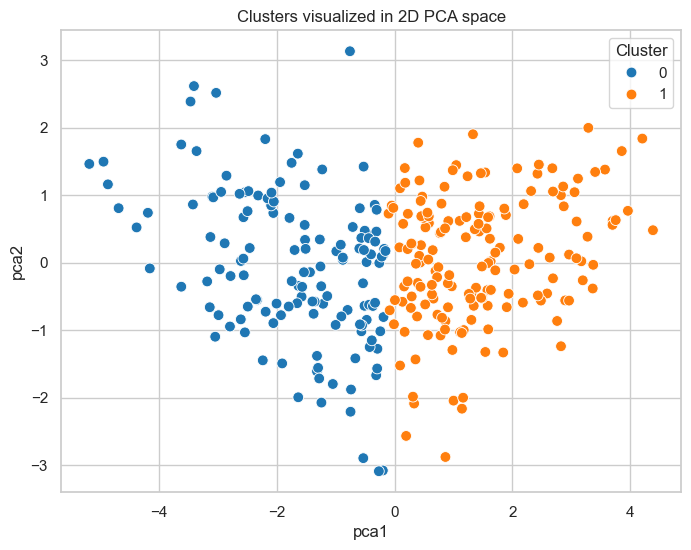

In [12]:
# 10. Visualize clusters (PCA 2D)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
df_fe['pca1'] = X_pca[:,0]
df_fe['pca2'] = X_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_fe, x='pca1', y='pca2', hue='cluster', palette='tab10', s=60)
plt.title('Clusters visualized in 2D PCA space')
plt.legend(title='Cluster')
plt.show()

In [13]:
# 11. Cluster profiling (centroids in original scale)
centroid_scaled = kmeans.cluster_centers_
centroid_unscaled = scaler.inverse_transform(centroid_scaled)
centroids_df = pd.DataFrame(centroid_unscaled, columns=features)
centroids_df['cluster'] = range(len(centroids_df))
display(centroids_df)


,eating_out_per_week,food_budget_per_meal_inr,sweet_tooth_level,weekly_hobby_hours,budget_log,wellness_proxy,cluster
0,1.623188,124.797101,1.869565,10.717391,4.749230,5.806418,0
1,4.598765,262.703704,3.141975,4.753086,5.514033,1.039666,1


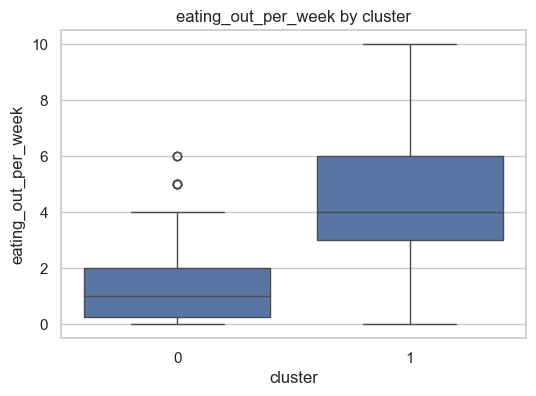

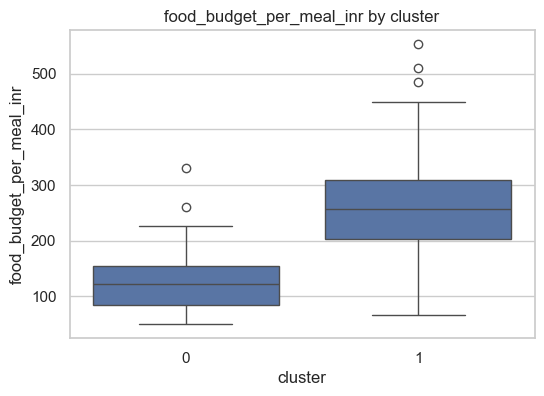

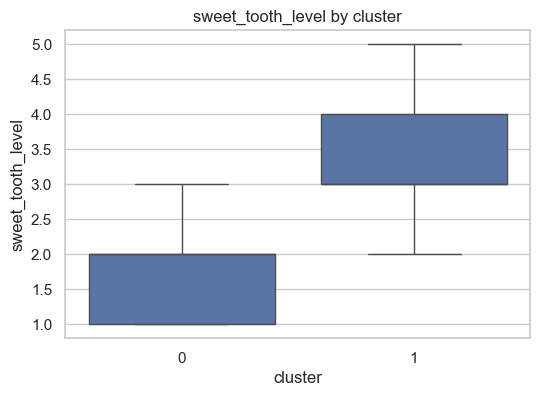

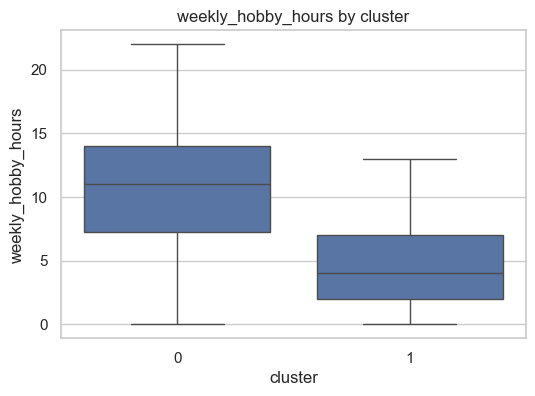

In [14]:
# 12. Boxplots for each feature by cluster
for col in ['eating_out_per_week','food_budget_per_meal_inr','sweet_tooth_level','weekly_hobby_hours']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='cluster', y=col, data=df_fe)
    plt.title(f'{col} by cluster')
    plt.show()


In [15]:
# 13. Save results
import os
os.makedirs("../data", exist_ok=True)
df_fe.to_csv('../data/clustered_results.csv', index=False)
print("✅ Saved clustered_results.csv in the current folder")


✅ Saved clustered_results.csv in the current folder


In [16]:
# 14. Interpret clusters and recommendations 
# Cluster 0: Low eating out, high hobby hours => "Health-conscious"
# Cluster 1: High eating out, low hobby hours => "Fast-food lovers"
# Cluster 2: Moderate everything => "Balanced"

# ===========================

In [17]:
# 15. Cluster Insights & Wellness Recommendations
# ===========================

import pandas as pd

df = pd.read_csv("../data/clustered_results.csv")

df.head()


,eating_out_per_week,food_budget_per_meal_inr,sweet_tooth_level,weekly_hobby_hours,budget_log,wellness_proxy,cluster,pca1,pca2
0,4.0,326.0,3.0,10.0,5.789960,2.000000,1,1.237794,1.278429
1,2.0,120.0,1.0,10.0,4.795791,3.333333,0,-1.633499,-0.345303
2,0.0,91.0,1.0,1.0,4.521789,1.000000,0,-1.319592,-1.612063
3,5.0,50.0,3.0,11.0,3.931826,1.833333,0,-1.243931,-2.074898
4,1.0,119.0,1.0,7.0,4.787492,3.500000,0,-1.581051,-0.505261


## SNU Contextual Insights

At **Sister Nivedita University**, these clusters can directly support initiatives such as:

- **Canteen Management:** Adjust menu and meal combos for each wellness persona (e.g., healthy salads for Cluster 0, low-cost balanced options for Cluster 2).

- **Wellness Clubs:** Create hobby-based groups (music, yoga, sports) targeting “Sedentary Scholars” to increase activity.

- **Mental Wellness Programs:** Use cluster insights to design personalized mental health or nutrition workshops.

- **Transport & Accessibility:** Students who eat out frequently may benefit from optimized shuttle timings or local food tie-ups.

**These actionable insights connect clustering outcomes to real-world improvements in student life at SNU.**